# *This file allows to generate all plots necessary for figures*

# **Useful packages and functions**

In [1]:
using DifferentialEquations, Plots, Polynomials, LaTeXStrings, ColorSchemes, DelimitedFiles, DataFrames
using Statistics, StatsPlots, Random, ProgressMeter, Printf, LinearAlgebra, Plots.PlotMeasures
include("DA_kinetics.jl") # Loading of DA kinetics of gating variables
include("DA_models.jl") # Loading of DA model
include("DA_utils.jl"); # Loading of some utils functions

# **Global variables**

In [2]:
# Definition of simulation time (in ms)
const Tfinal = 20000
const tspan  = (0.0, Tfinal)
tt = 0. : 0.01 : Tfinal
tt_rand = 0. : 1 : Tfinal
tt_plot = 0. : 0.01 : 20000.

# Definition of reversal potential values (in mV), [Mg] and membrane capacitance
const VNa     = 60. # Sodium reversal potential
const VK      = -90. # Potassium reversal potential
const VCa     = 50. # Calcium reversal potential
const VH      = -29. # H reversal potential
const VLNS    = -65. # Leak reversal potential
const EPacemaker = 4.2732015978991615 # Reversal potential of pacemaking channels

const C       = 1. # Membrane capacitance
const fCa     = 0.018 # Fraction of unbuffered free calcium
const ICapmax = 11 # Maximum calcium pump current
const F       = 96520 # Faraday constant in ms*µA/mmol (and taking cm³=mL)
const d       = 15 # Soma diameter in cm
const L       = 25 # Soma length

# Definition of voltage range for the DICs
const Vmin = -100 
const Vmax = 50
const Vrange = range(Vmin, stop=Vmax, step=0.0154640);

In [3]:
# Modifying backend GR attributes
gr(guidefontsize=25, tickfontsize=15, legendfontsize=12, margin=5Plots.mm, grid=false)
myApple = RGBA(187/255, 206/255, 131/255, 1)
mySalmon = RGBA(243/255, 124/255, 130/255)
myYellow = RGBA(228/255, 205/255, 121/255, 1)
myBlue = RGBA(131/255, 174/255, 218/255, 1)
myDarkBlue = RGBA(114/255, 119/255, 217/255, 1)
myOrange = RGBA(241/255, 175/255, 113/255, 1)
myPink = RGBA(243/255, 124/255, 130/255, 1)
myPurple = RGBA(169/255, 90/255, 179/255, 1)
myGreen = RGBA(132/255, 195/255, 168/255, 1)
myRed = RGBA(158/255, 3/255, 8/255, 1)
myGray = RGBA(150/255, 150/255, 150/255, 1)
myLightBlue = RGBA(127/255, 154/255, 209/255, 1);
default(fmt = :png);

In [4]:
# Define a struct (optional, but useful if you need parameters)
struct NoisyFunction
    amplitude::Float64  # amplitude of the noise
end

# Overload the () operator to make the struct callable
function (nf::NoisyFunction)(x::Float64)
    noise = nf.amplitude * randn()  # Generate Gaussian noise (mean 0, std 1)
    return noise  # Example function with noise
end

function condition(u,t,integrator) # Event when event_f(u,t) == 0
  (u[1]- (-20.))
end

function affect!(integrator)
end

cb = ContinuousCallback(condition, affect!, nothing, save_positions = (true, false));

In [5]:
function computeCurrents(sol, tt, t_min, t_max, p)
    # Parameters
    Iapp       = p[1](0) # Amplitude of constant applied current
    gNa        = p[2] # Sodium current maximal conductance
    gCaL       = p[3] # L-type calcium current maximal conductance
    gKd        = p[4] # Delayed-rectifier potassium current maximal conductance
    gKA        = p[5] # A-type potassium current maximal conductance
    gKERG      = p[6] # ERG potassium current maximal conductance
    gKSK       = p[7] # SK current maximal conductance
    gH         = p[8] # SK current maximal conductance
    gLNS       = p[9] # Leak non specific current maximal conductance
    gLCa       = p[10] # Leak calcium current maximal conductance
    gPacemaker = p[11] # Pacemaking current maximal conductance
    
    # Retrieving variables
    x         = sol(tt)
    V_plot    = x[1, :]
    m_plot    = x[2, :]
    h_plot    = x[3, :]
    hs_plot   = x[4, :]
    l_plot    = x[5, :]
    n_plot    = x[6, :]
    p_plot    = x[7, :]
    q1_plot   = x[8, :]
    q2_plot   = x[9, :]
    o_plot    = x[10, :]
    i_plot    = x[11, :]
    mH_plot   = x[12, :]
    Ca_plot   = x[13, :]

    SK_inf_plot = zeros(length(tt))
    for i = 1 : length(tt)
        if Ca_plot[i] > 0
            SK_inf_plot[i] = 1/(1+(0.00019/Ca_plot[i])^4)
        end
    end

    # Computing currents
    INa = ((pi*d*L) / 100) .* gNa .* m_plot.^3 .* h_plot .* (V_plot .- VNa)
    ICaL = ((pi*d*L) / 100) .* gCaL .* l_plot .* (V_plot .- VCa)
    IKd = ((pi*d*L) / 100) .* gKd .* n_plot.^3 .* (V_plot .- VK)
    IKA = ((pi*d*L) / 100) .* gKA .* p_plot .* (q1_plot ./ 2 .+ q2_plot ./ 2) .* (V_plot .- VK)
    IKERG = ((pi*d*L) / 100) .* gKERG .* o_plot .* (V_plot .- VK)
    IKSK = ((pi*d*L) / 100) .* gKSK .* SK_inf_plot .* (V_plot .- VK)
    IH = ((pi*d*L) / 100) .* gH .* mH_plot .* (V_plot .- VH)
    ILCa = ((pi*d*L) / 100) .* gLCa .* (V_plot .- VCa)
    ILNS = ((pi*d*L) / 100) .* gLNS .* (V_plot .- VLNS)
    IPacemaker = ((pi*d*L) / 100) .* gPacemaker .* mPacemaker_inf.(V_plot) .* (V_plot .- EPacemaker)

    # Splitting inward and outward currents
    INa_out = max.(INa, 0)
    INa_in = min.(INa, 0)
    ICaL_out = max.(ICaL, 0)
    ICaL_in = min.(ICaL, 0)
    IKd_out = max.(IKd, 0)
    IKd_in = min.(IKd, 0)
    IKA_out = max.(IKA, 0)
    IKA_in = min.(IKA, 0)
    IKERG_out = max.(IKERG, 0)
    IKERG_in = min.(IKERG, 0)
    IKSK_out = max.(IKSK, 0)
    IKSK_in = min.(IKSK, 0)
    IH_out = max.(IH, 0)
    IH_in = min.(IH, 0)
    ILCa_out = max.(ILCa, 0)
    ILCa_in = min.(ILCa, 0)
    ILNS_out = max.(ILNS, 0)
    ILNS_in = min.(ILNS, 0)
    IPace_out = max.(IPacemaker, 0)
    IPace_in = min.(IPacemaker, 0)
    I_in = INa_in .+ ICaL_in .+ IKd_in .+ IKA_in .+ IKERG_in .+ IKSK_in .+ 
           IH_in .+ ILCa_in .+ ILNS_in .+ IPace_in
    I_out = INa_out .+ ICaL_out .+ IKd_out .+ IKA_out .+ IKERG_out .+ IKSK_out .+ 
            IH_out .+ ILCa_out .+ ILNS_out .+ IPace_out

    return I_in, I_out
end

computeCurrents (generic function with 1 method)

In [6]:
function currentScape(sol, tt, t_min, t_max, p)
    # Parameters
    Iapp       = p[1](0) # Amplitude of constant applied current
    gNa        = p[2] # Sodium current maximal conductance
    gCaL       = p[3] # L-type calcium current maximal conductance
    gKd        = p[4] # Delayed-rectifier potassium current maximal conductance
    gKA        = p[5] # A-type potassium current maximal conductance
    gKERG      = p[6] # ERG potassium current maximal conductance
    gKSK       = p[7] # SK current maximal conductance
    gH         = p[8] # SK current maximal conductance
    gLNS       = p[9] # Leak non specific current maximal conductance
    gLCa       = p[10] # Leak calcium current maximal conductance
    gPacemaker = p[11] # Pacemaking current maximal conductance
    
    # Retrieving variables
    x         = sol(tt)
    V_plot    = x[1, :]
    m_plot    = x[2, :]
    h_plot    = x[3, :]
    hs_plot   = x[4, :]
    l_plot    = x[5, :]
    n_plot    = x[6, :]
    p_plot    = x[7, :]
    q1_plot   = x[8, :]
    q2_plot   = x[9, :]
    o_plot    = x[10, :]
    i_plot    = x[11, :]
    mH_plot   = x[12, :]
    Ca_plot   = x[13, :]

    SK_inf_plot = zeros(length(tt))
    for i = 1 : length(tt)
        if Ca_plot[i] > 0
            SK_inf_plot[i] = 1/(1+(0.00019/Ca_plot[i])^4)
        end
    end

    # Computing currents
    INa = ((pi*d*L) / 100) .* gNa .* m_plot.^3 .* h_plot .* (V_plot .- VNa)
    ICaL = ((pi*d*L) / 100) .* gCaL .* l_plot .* (V_plot .- VCa)
    IKd = ((pi*d*L) / 100) .* gKd .* n_plot.^3 .* (V_plot .- VK)
    IKA = ((pi*d*L) / 100) .* gKA .* p_plot .* (q1_plot ./ 2 .+ q2_plot ./ 2) .* (V_plot .- VK)
    IKERG = ((pi*d*L) / 100) .* gKERG .* o_plot .* (V_plot .- VK)
    IKSK = ((pi*d*L) / 100) .* gKSK .* SK_inf_plot .* (V_plot .- VK)
    IH = ((pi*d*L) / 100) .* gH .* mH_plot .* (V_plot .- VH)
    ILCa = ((pi*d*L) / 100) .* gLCa .* (V_plot .- VCa)
    ILNS = ((pi*d*L) / 100) .* gLNS .* (V_plot .- VLNS)
    IPacemaker = ((pi*d*L) / 100) .* gPacemaker .* mPacemaker_inf.(V_plot) .* (V_plot .- EPacemaker)

    # Splitting inward and outward currents
    INa_out = max.(INa, 0)
    INa_in = min.(INa, 0)
    ICaL_out = max.(ICaL, 0)
    ICaL_in = min.(ICaL, 0)
    IKd_out = max.(IKd, 0)
    IKd_in = min.(IKd, 0)
    IKA_out = max.(IKA, 0)
    IKA_in = min.(IKA, 0)
    IKERG_out = max.(IKERG, 0)
    IKERG_in = min.(IKERG, 0)
    IKSK_out = max.(IKSK, 0)
    IKSK_in = min.(IKSK, 0)
    IH_out = max.(IH, 0)
    IH_in = min.(IH, 0)
    ILCa_out = max.(ILCa, 0)
    ILCa_in = min.(ILCa, 0)
    ILNS_out = max.(ILNS, 0)
    ILNS_in = min.(ILNS, 0)
    IPace_out = max.(IPacemaker, 0)
    IPace_in = min.(IPacemaker, 0)
    I_in = INa_in .+ ICaL_in .+ IKd_in .+ IKA_in .+ IKERG_in .+ IKSK_in .+ 
           IH_in .+ ILCa_in .+ ILNS_in .+ IPace_in
    I_out = INa_out .+ ICaL_out .+ IKd_out .+ IKA_out .+ IKERG_out .+ IKSK_out .+ 
            IH_out .+ ILCa_out .+ ILNS_out .+ IPace_out
    
    voltage = plot(tt./1e3, V_plot, linewidth=2.5, color=myGray, legend=false, ylims=(-90, 30), 
        margins=0Plots.px, size=(1200, 800), xaxis=false, xticks=false, 
        yticks=([-80, -60, -40, -20, 0, 20]))
    ylabel!("V (mV)")

    outward_cur = plot(tt./1e3, I_out, linewidth=2.5, color=myGray, fillrange=zeros(length(tt)) .+ 1e-10,
        legend=false, margins=0Plots.px, size=(1200, 800), xaxis=false, xticks=false, 
        yscale=:log10, ylims=(1e0, 1e4), bottom_margin=-8Plots.px, yticks=([1e0, 1e2, 1e4]))
    ylabel!("I out (pA)")

    outward_cur_distr = plot(tt./1e3, zeros(length(tt)), linewidth=0, color=3, yticks=false,
        fillrange=100 .* (INa_out) ./ I_out, legend=:topright, margins=0Plots.px, size=(1200, 800), 
        xaxis=false, xticks=false, ylims=(0, 100), label="INa", 
        top_margin=-8Plots.px, bottom_margin=-8Plots.px)

    plot!(tt./1e3, 100 .* (INa_out) ./ I_out, linewidth=0, color=2, 
        fillrange=100 .* (INa_out .+ ICaL_out) ./ I_out, label="ICaL")

    plot!(tt./1e3, 100 .* (INa_out .+ ICaL_out) ./ I_out, linewidth=0, color=1, 
        fillrange=100 .* (INa_out .+ ICaL_out .+ IKd_out) ./ I_out, label="IKd")

    plot!(tt./1e3, 100 .* (INa_out .+ ICaL_out .+ IKd_out) ./ I_out, linewidth=0, color=4, 
        fillrange=100 .* (INa_out .+ ICaL_out .+ IKd_out .+ IKA_out) ./ I_out, label="IKA")

    plot!(tt./1e3, 100 .* (INa_out .+ ICaL_out .+ IKd_out .+ IKA_out) ./ I_out, linewidth=0, color=5, 
        fillrange=100 .* (INa_out .+ ICaL_out .+ IKd_out .+ IKA_out .+ 
                          IKERG_out) ./ I_out, label="IKERG")

    plot!(tt./1e3, 100 .* (INa_out .+ ICaL_out .+ IKd_out .+ IKA_out .+ 
                           IKERG_out) ./ I_out, linewidth=0, color=7, 
        fillrange=100 .* (INa_out .+ ICaL_out .+ IKd_out .+ IKA_out .+ 
                          IKERG_out .+ IKSK_out) ./ I_out, label="IKSK")

    plot!(tt./1e3, 100 .* (INa_out .+ ICaL_out .+ IKd_out .+ IKA_out .+ 
                           IKERG_out .+ IKSK_out) ./ I_out, linewidth=0, color=6, 
        fillrange=100 .* (INa_out .+ ICaL_out .+ IKd_out .+ IKA_out .+ 
                          IKERG_out .+ IKSK_out .+ IH_out) ./ I_out, label="IH")

    plot!(tt./1e3, 100 .* (INa_out .+ ICaL_out .+ IKd_out .+ IKA_out .+ 
                           IKERG_out .+ IKSK_out .+ IH_out) ./ I_out, linewidth=0, color=8, 
        fillrange=100 .* (INa_out .+ ICaL_out .+ IKd_out .+ IKA_out .+ 
                          IKERG_out .+ IKSK_out .+ IH_out .+ ILCa_out) ./ I_out, label="ILCa")

    plot!(tt./1e3, 100 .* (INa_out .+ ICaL_out .+ IKd_out .+ IKA_out .+ 
                           IKERG_out .+ IKSK_out .+ IH_out .+ ILCa_out) ./ I_out, linewidth=0, color=myApple, 
        fillrange=100 .* (INa_out .+ ICaL_out .+ IKd_out .+ IKA_out .+ 
                          IKERG_out .+ IKSK_out .+ IH_out .+ ILCa_out .+ ILNS_out) ./ I_out, label="ILNS")
    
    plot!(tt./1e3, 100 .* (INa_out .+ ICaL_out .+ IKd_out .+ IKA_out .+ 
                           IKERG_out .+ IKSK_out .+ IH_out .+ ILCa_out .+ 
                           ILNS_out) ./ I_out, linewidth=0, color=myRed, 
        fillrange=100 .* (INa_out .+ ICaL_out .+ IKd_out .+ IKA_out .+ 
                          IKERG_out .+ IKSK_out .+ IH_out .+ ILCa_out .+ 
                          ILNS_out .+ IPace_out) ./ I_out, label="IPace")
    ylabel!("outward (%)")

    inward_cur_distr = plot(tt./1e3, zeros(length(tt)), linewidth=0, color=3, yticks=false,
        fillrange=100 .* (INa_in) ./ I_in, legend=false, margins=0Plots.px, size=(1200, 800), 
        xaxis=false, xticks=false, ylims=(0, 100), label="INa", 
        top_margin=-8Plots.px, bottom_margin=-8Plots.px)

    plot!(tt./1e3, 100 .* (INa_in) ./ I_in, linewidth=0, color=2, 
        fillrange=100 .* (INa_in .+ ICaL_in) ./ I_in, label="ICaL")

    plot!(tt./1e3, 100 .* (INa_in .+ ICaL_in) ./ I_in, linewidth=0, color=1, 
        fillrange=100 .* (INa_in .+ ICaL_in .+ IKd_in) ./ I_in, label="IKd")

    plot!(tt./1e3, 100 .* (INa_in .+ ICaL_in .+ IKd_in) ./ I_in, linewidth=0, color=4, 
        fillrange=100 .* (INa_in .+ ICaL_in .+ IKd_in .+ IKA_in) ./ I_in, label="IKA")

    plot!(tt./1e3, 100 .* (INa_in .+ ICaL_in .+ IKd_in .+ IKA_in) ./ I_in, linewidth=0, color=5, 
        fillrange=100 .* (INa_in .+ ICaL_in .+ IKd_in .+ IKA_in .+ 
                          IKERG_in) ./ I_in, label="IKERG")

    plot!(tt./1e3, 100 .* (INa_in .+ ICaL_in .+ IKd_in .+ IKA_in .+ 
                           IKERG_in) ./ I_in, linewidth=0, color=7, 
        fillrange=100 .* (INa_in .+ ICaL_in .+ IKd_in .+ IKA_in .+ 
                          IKERG_in .+ IKSK_in) ./ I_in, label="IKSK")

    plot!(tt./1e3, 100 .* (INa_in .+ ICaL_in .+ IKd_in .+ IKA_in .+ 
                           IKERG_in .+ IKSK_in) ./ I_in, linewidth=0, color=6, 
        fillrange=100 .* (INa_in .+ ICaL_in .+ IKd_in .+ IKA_in .+ 
                          IKERG_in .+ IKSK_in .+ IH_in) ./ I_in, label="IH")

    plot!(tt./1e3, 100 .* (INa_in .+ ICaL_in .+ IKd_in .+ IKA_in .+ 
                           IKERG_in .+ IKSK_in .+ IH_in) ./ I_in, linewidth=0, color=8, 
        fillrange=100 .* (INa_in .+ ICaL_in .+ IKd_in .+ IKA_in .+ 
                          IKERG_in .+ IKSK_in .+ IH_in .+ ILCa_in) ./ I_in, label="ILCa")

    plot!(tt./1e3, 100 .* (INa_in .+ ICaL_in .+ IKd_in .+ IKA_in .+ 
                           IKERG_in .+ IKSK_in .+ IH_in .+ ILCa_in) ./ I_in, linewidth=0, color=myApple, 
        fillrange=100 .* (INa_in .+ ICaL_in .+ IKd_in .+ IKA_in .+ 
                          IKERG_in .+ IKSK_in .+ IH_in .+ ILCa_in .+ ILNS_in) ./ I_in, label="ILNS")
    
    plot!(tt./1e3, 100 .* (INa_in .+ ICaL_in .+ IKd_in .+ IKA_in .+ 
                           IKERG_in .+ IKSK_in .+ IH_in .+ ILCa_in .+ 
                           ILNS_in) ./ I_in, linewidth=0, color=myRed, 
        fillrange=100 .* (INa_in .+ ICaL_in .+ IKd_in .+ IKA_in .+ 
                          IKERG_in .+ IKSK_in .+ IH_in .+ ILCa_in .+ 
                          ILNS_in .+ IPace_in) ./ I_in, label="IPace")
    ylabel!("inward (%)")

    inward_cur = plot(tt./1e3, -I_in, linewidth=2.5, color=myGray, fillrange=zeros(length(tt)) .+ 1e-10,
        legend=false, margins=0Plots.px, size=(1200, 800), top_margin=-8Plots.px,
        yscale=:log10, ylims=(1e0, 1e4), yflip=true, xticks=([t_min, t_max], ["0", "1"]),
        yticks=([1e0, 1e2, 1e4]))
    ylabel!("I in (-pA)")
    xlabel!("t (s)")

    l = @layout [
        a{1.0*w, 0.2*h}
        b{1.0*w, 0.1*h}
        c{1.0*w, 0.3*h}
        d{1.0*w, 0.3*h}
        d{1.0*w, 0.1*h}
    ]
    currentscape = plot(voltage, outward_cur, outward_cur_distr, inward_cur_distr, inward_cur, 
                        layout=l, size=(1000, 1500), xlims=(t_min, t_max), left_margin=30Plots.px,
                        right_margin=0Plots.px)#, dpi=300)
    
    return currentscape
end

currentScape (generic function with 1 method)

# **Figure 6**

# Simu noisy model instantaneous Na Kd only

In [7]:
gNa        = 25. # Sodium current maximal conductance
gCaL       = 0. # L-type calcium current maximal conductance
gKd        = 10. # Delayed-rectifier potassium current maximal conductance
gKA        = 0. # A-type potassium current maximal conductance
gKERG      = 0. # ERG current maximal conductance
gKSK       = 0. # SK current maximal conductance
gH         = 0. # H current maximal conductance
gLNS       = 0.01 # Leak non specific current maximal conductance
gLCa       = 0. # Leak calcium current maximal conductance
gPacemaker = 5. # Pacemaker current maximal conductance

# Parameter vector for simulations
Iapp(t) = 0
p = (Iapp, gNa, gCaL, gKd, gKA, gKERG, gKSK, gH, gLNS, gLCa, gPacemaker)

# Initial conditions
V0 = 0.
Ca0 = 1e-4
x0 = [V0, m_inf(V0), h_inf(V0), hs_inf(V0), l_inf(V0), n_inf(V0), p_inf(V0), q1_inf(V0), q2_inf(V0), 
    0., 0., mH_inf(V0), Ca0]    

# Simulation
prob = ODEProblem(DA_ODE_true_instant, x0, tspan, p) # Describing the problem
sol_NaKdi = solve(prob, Tsit5(); maxiters=1e9);

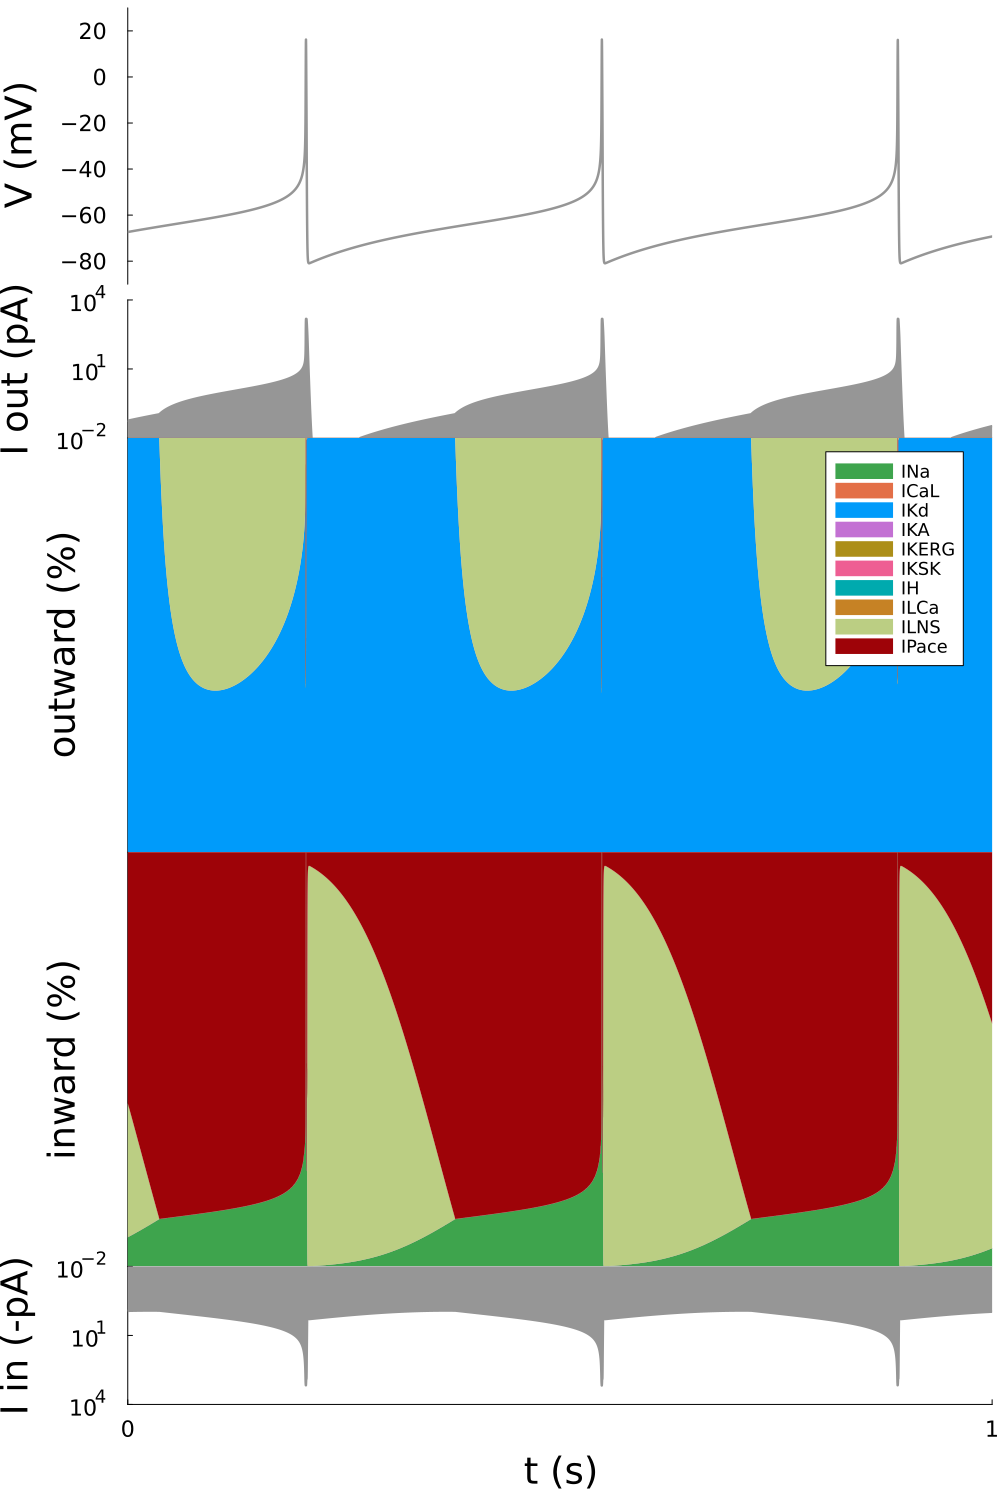

In [12]:
tt_currentscapte = 19000 : 0.1 : 20000
currentscapeNaKd = currentScape(sol_NaKdi, tt_currentscapte, 19, 20, p)
display(currentscapeNaKd)
# savefig(currentscapeNaKd, "./figures/fig6_currentscapeNaKd.png")
# savefig(currentscapeNaKd, "./figures/fig6_currentscapeNaKd.pdf")
# savefig(currentscapeNaKd, "./figures/fig6_currentscapeNaKd.svg")

# Simu noisy model instantaneous with SK

In [9]:
gNa        = 25. # Sodium current maximal conductance
gCaL       = 1. # L-type calcium current maximal conductance
gKd        = 10. # Delayed-rectifier potassium current maximal conductance
gKA        = 0. # A-type potassium current maximal conductance
gKERG      = 0.13 # ERG current maximal conductance
gKSK       = 0.3 # SK current maximal conductance
gH         = 0. # H current maximal conductance
gLNS       = 0.01 # Leak non specific current maximal conductance
gLCa       = 0.00245 # Leak calcium current maximal conductance
gPacemaker = 5 # Pacemaker current maximal conductance

# Parameter vector for simulations
Iapp(t) = 0
p = (Iapp, gNa, gCaL, gKd, gKA, gKERG, gKSK, gH, gLNS, gLCa, gPacemaker)

# Initial conditions
V0 = 0.
Ca0 = 1e-4
x0 = [V0, m_inf(V0), h_inf(V0), hs_inf(V0), l_inf(V0), n_inf(V0), p_inf(V0), q1_inf(V0), q2_inf(V0), 
    0., 0., mH_inf(V0), Ca0]


# Simulation
prob = ODEProblem(DA_ODE_true_instant, x0, tspan, p) # Describing the problem
sol_SKi = solve(prob, Tsit5(); maxiters=1e9);

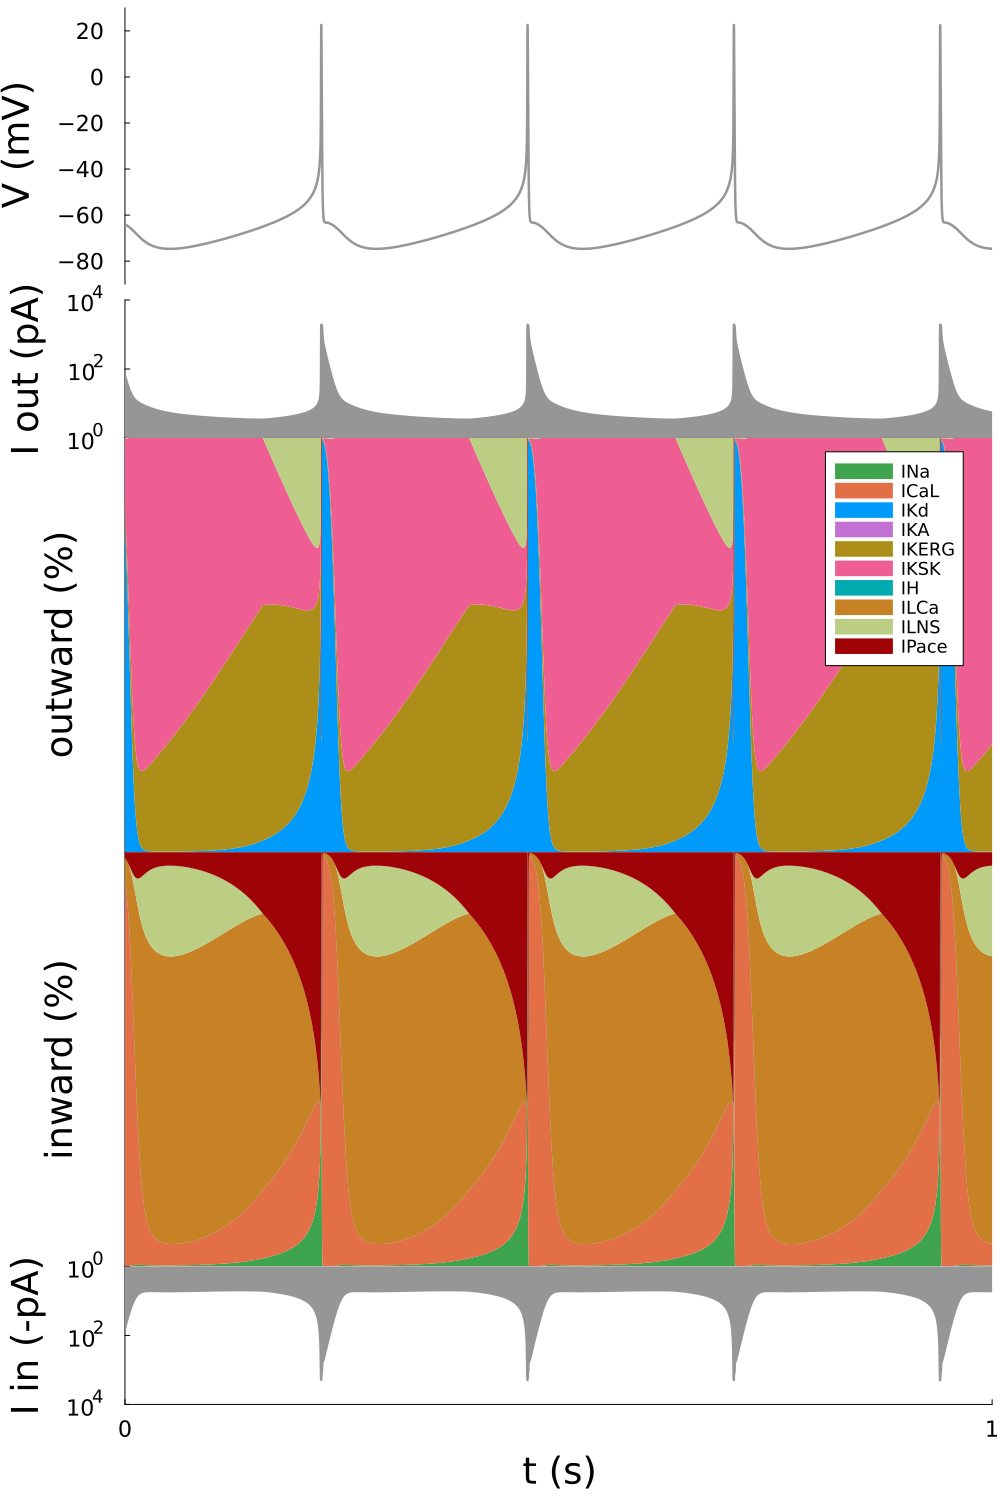

In [10]:
tt_currentscapte = 19000 : 0.1 : 20000
currentscapeSK = currentScape(sol_SKi, tt_currentscapte, 19, 20, p)
display(currentscapeSK)
# savefig(currentscapeSK, "./figures/fig6_currentscapeSK.png")
# savefig(currentscapeSK, "./figures/fig6_currentscapeSK.pdf")
# savefig(currentscapeSK, "./figures/fig6_currentscapeSK.svg")

# Simu noisy model instantaneous with H

In [11]:
gNa        = 25. # Sodium current maximal conductance
gCaL       = 0. # L-type calcium current maximal conductance
gKd        = 10. # Delayed-rectifier potassium current maximal conductance
gKA        = 0. # A-type potassium current maximal conductance
gKERG      = 0.13 # ERG current maximal conductance
gKSK       = 0. # SK current maximal conductance
gH         = 0.078 # H current maximal conductance
gLNS       = 0.01 # Leak non specific current maximal conductance
gLCa       = 0.00245 # Leak calcium current maximal conductance
gPacemaker = 5 # Pacemaker current maximal conductance

# Parameter vector for simulations
Iapp(t) = 0
p = (Iapp, gNa, gCaL, gKd, gKA, gKERG, gKSK, gH, gLNS, gLCa, gPacemaker)

# Initial conditions
V0 = 0.
Ca0 = 1e-4
x0 = [V0, m_inf(V0), h_inf(V0), hs_inf(V0), l_inf(V0), n_inf(V0), p_inf(V0), q1_inf(V0), q2_inf(V0), 
    0., 0., mH_inf(V0), Ca0]

# Simulation
prob = ODEProblem(DA_ODE_true_instant, x0, tspan, p) # Describing the problem
sol_Hi = solve(prob, Tsit5(); maxiters=1e9);

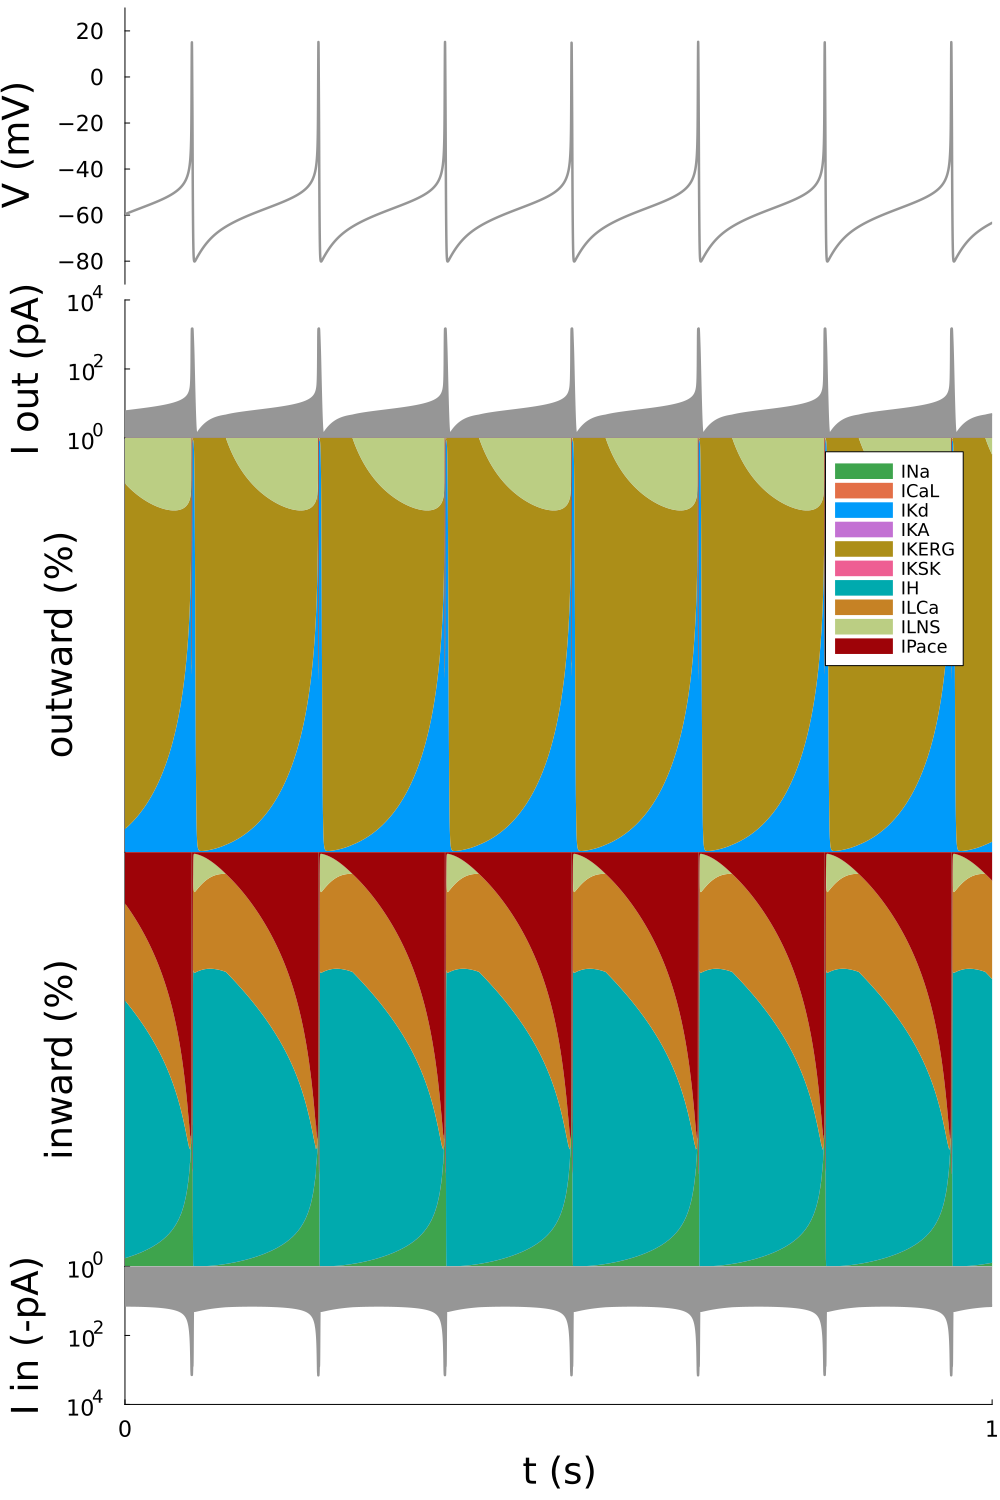

In [12]:
tt_currentscapte = 19000 : 0.1 : 20000
currentscapeH = currentScape(sol_Hi, tt_currentscapte, 19, 20, p)
display(currentscapeH)
# savefig(currentscapeH, "./figures/fig6_currentscapeH.png")
# savefig(currentscapeH, "./figures/fig6_currentscapeH.pdf")
# savefig(currentscapeH, "./figures/fig6_currentscapeH.svg")

# Simu noisy model instantaneous with H and A

In [13]:
gNa        = 25. # Sodium current maximal conductance
gCaL       = 0. # L-type calcium current maximal conductance
gKd        = 10. # Delayed-rectifier potassium current maximal conductance
gKA        = 1.68 # A-type potassium current maximal conductance
gKERG      = 0.13 # ERG current maximal conductance
gKSK       = 0. # SK current maximal conductance
gH         = 0.078 # H current maximal conductance
gLNS       = 0.01 # Leak non specific current maximal conductance
gLCa       = 0.00245 # Leak calcium current maximal conductance
gPacemaker = 5 # Pacemaker current maximal conductance

# Parameter vector for simulations
Iapp(t) = 0
p = (Iapp, gNa, gCaL, gKd, gKA, gKERG, gKSK, gH, gLNS, gLCa, gPacemaker)

# Initial conditions
V0 = 0.
Ca0 = 1e-4
x0 = [V0, m_inf(V0), h_inf(V0), hs_inf(V0), l_inf(V0), n_inf(V0), p_inf(V0), q1_inf(V0), q2_inf(V0), 
    0., 0., mH_inf(V0), Ca0]

# Simulation
prob = ODEProblem(DA_ODE_true_instant, x0, tspan, p) # Describing the problem
sol_HAi = solve(prob, Tsit5(); maxiters=1e9);

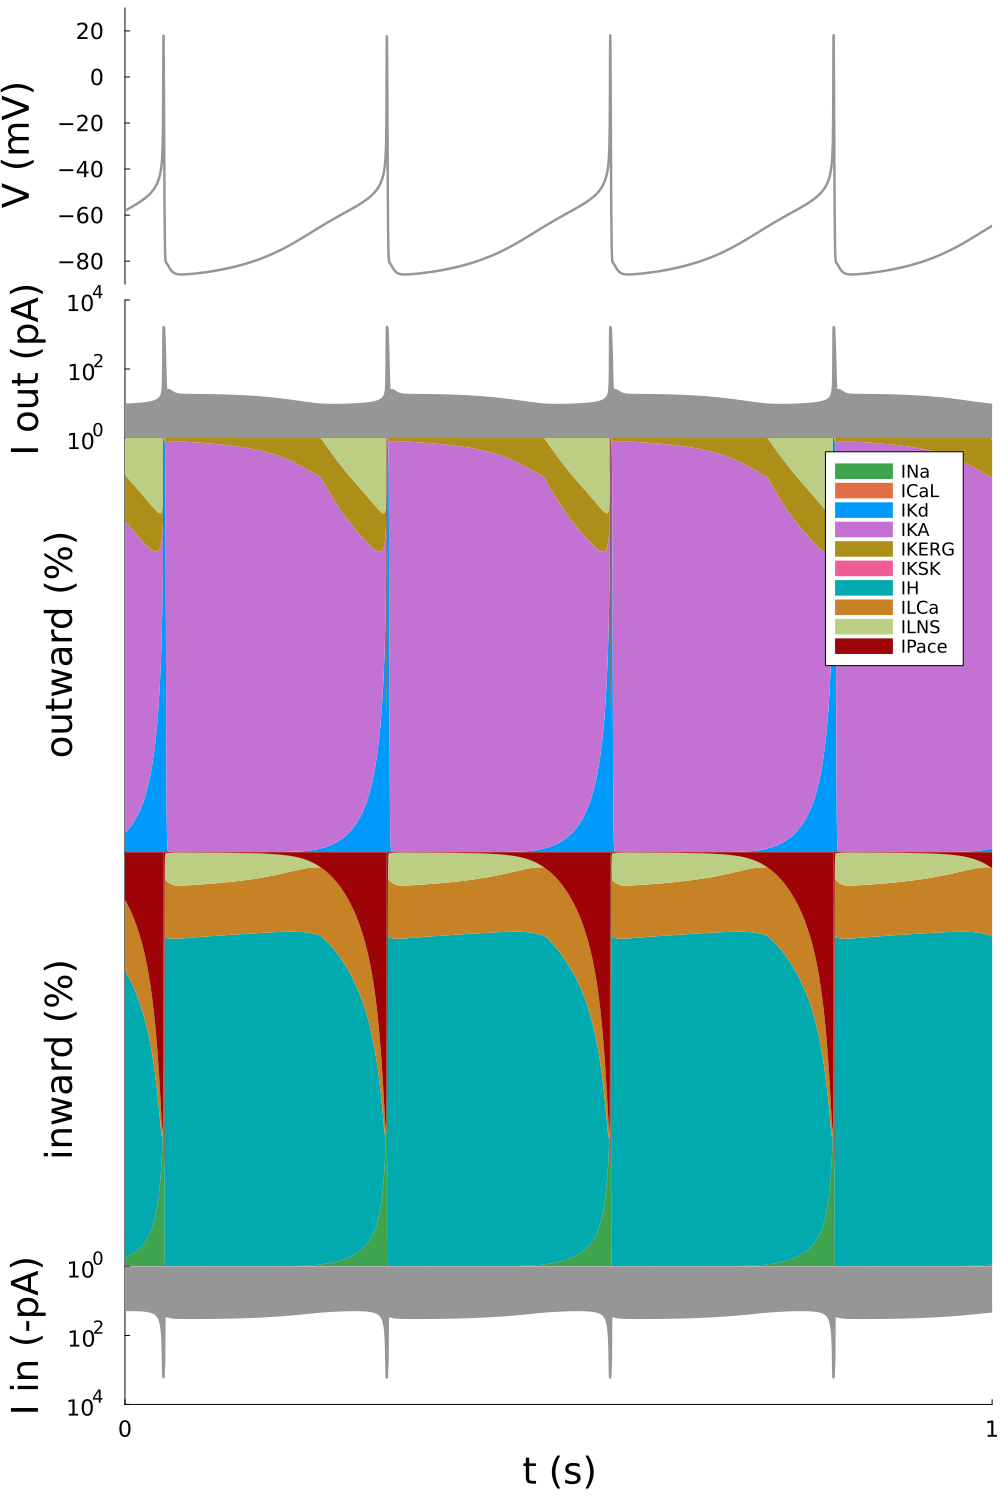

In [14]:
tt_currentscapte = 19000 : 0.1 : 20000
currentscapeHA = currentScape(sol_HAi, tt_currentscapte, 19, 20, p)
display(currentscapeHA)
# savefig(currentscapeHA, "./figures/fig6_currentscapeHA.png")
# savefig(currentscapeHA, "./figures/fig6_currentscapeHA.pdf")
# savefig(currentscapeHA, "./figures/fig6_currentscapeHA.svg")

# Simu noisy model instantaneous with H and SK

In [15]:
gNa        = 25. # Sodium current maximal conductance
gCaL       = 1. # L-type calcium current maximal conductance
gKd        = 10. # Delayed-rectifier potassium current maximal conductance
gKA        = 0. # A-type potassium current maximal conductance
gKERG      = 0.13 # ERG current maximal conductance
gKSK       = 0.3 # SK current maximal conductance
gH         = 0.078 # H current maximal conductance
gLNS       = 0.01 # Leak non specific current maximal conductance
gLCa       = 0.00245 # Leak calcium current maximal conductance
gPacemaker = 5 # Pacemaker current maximal conductance

# Parameter vector for simulations
Iapp(t) = 0
p = (Iapp, gNa, gCaL, gKd, gKA, gKERG, gKSK, gH, gLNS, gLCa, gPacemaker)

# Initial conditions
V0 = 0.
Ca0 = 1e-4
x0 = [V0, m_inf(V0), h_inf(V0), hs_inf(V0), l_inf(V0), n_inf(V0), p_inf(V0), q1_inf(V0), q2_inf(V0), 
    0., 0., mH_inf(V0), Ca0]

# Simulation
prob = ODEProblem(DA_ODE_true_instant, x0, tspan, p) # Describing the problem
sol_HSKi = solve(prob, Tsit5(); maxiters=1e9);

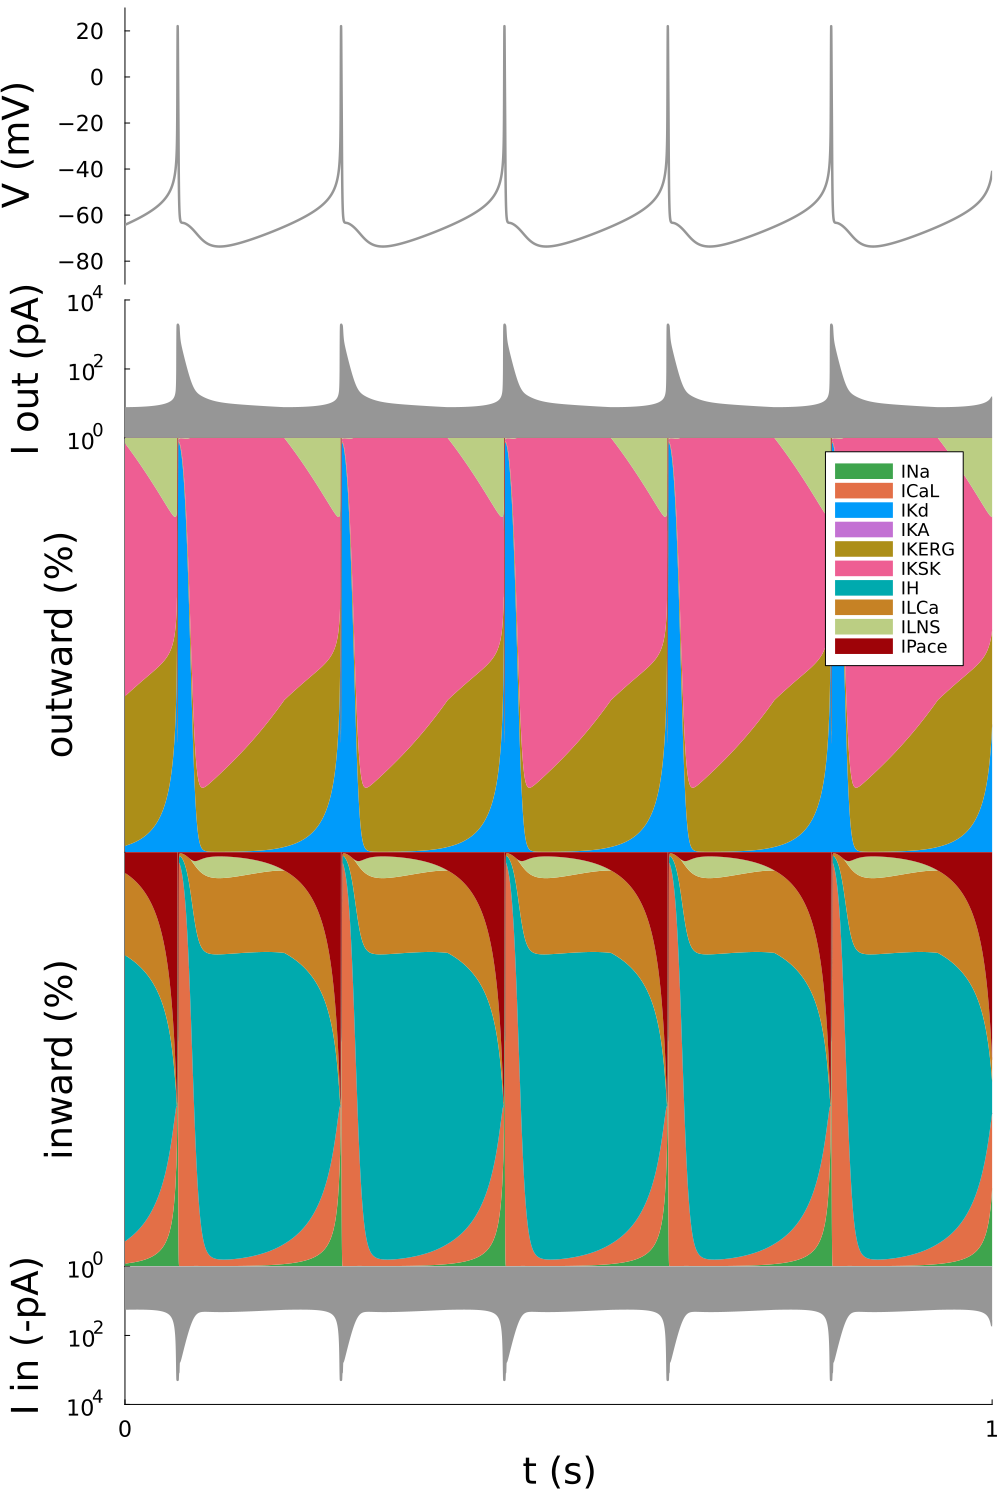

In [16]:
tt_currentscapte = 19000 : 0.1 : 20000
currentscapeHSK = currentScape(sol_HSKi, tt_currentscapte, 19, 20, p)
display(currentscapeHSK)
# savefig(currentscapeHSK, "./figures/fig6_currentscapeHSK.png")
# savefig(currentscapeHSK, "./figures/fig6_currentscapeHSK.pdf")
# savefig(currentscapeHSK, "./figures/fig6_currentscapeHSK.svg")

# Simu noisy model instantaneous with all

In [36]:
gNa        = 25. # Sodium current maximal conductance
gCaL       = 1. # L-type calcium current maximal conductance
gKd        = 10. # Delayed-rectifier potassium current maximal conductance
gKA        = 1.68 # A-type potassium current maximal conductance
gKERG      = 0.13 # ERG current maximal conductance
gKSK       = 0.3 # SK current maximal conductance
gH         = 0.078 # H current maximal conductance
gLNS       = 0.01 # Leak non specific current maximal conductance
gLCa       = 0.00245 # Leak calcium current maximal conductance
gPacemaker = 5 # Pacemaker current maximal conductance

# Parameter vector for simulations
Iapp(t) = 0
p = (Iapp, gNa, gCaL, gKd, gKA, gKERG, gKSK, gH, gLNS, gLCa, gPacemaker)

# Initial conditions
V0 = 0.
Ca0 = 1e-4
x0 = [V0, m_inf(V0), h_inf(V0), hs_inf(V0), l_inf(V0), n_inf(V0), p_inf(V0), q1_inf(V0), q2_inf(V0), 
    0., 0., mH_inf(V0), Ca0]

# Simulation
prob = ODEProblem(DA_ODE_true_instant, x0, tspan, p) # Describing the problem
sol_AHSKi = solve(prob, Tsit5(); maxiters=1e9);

In [37]:
I_in_AHSK, I_out_AHSK = computeCurrents(sol_AHSKi, tt_currentscapte, 19, 19.7, p);

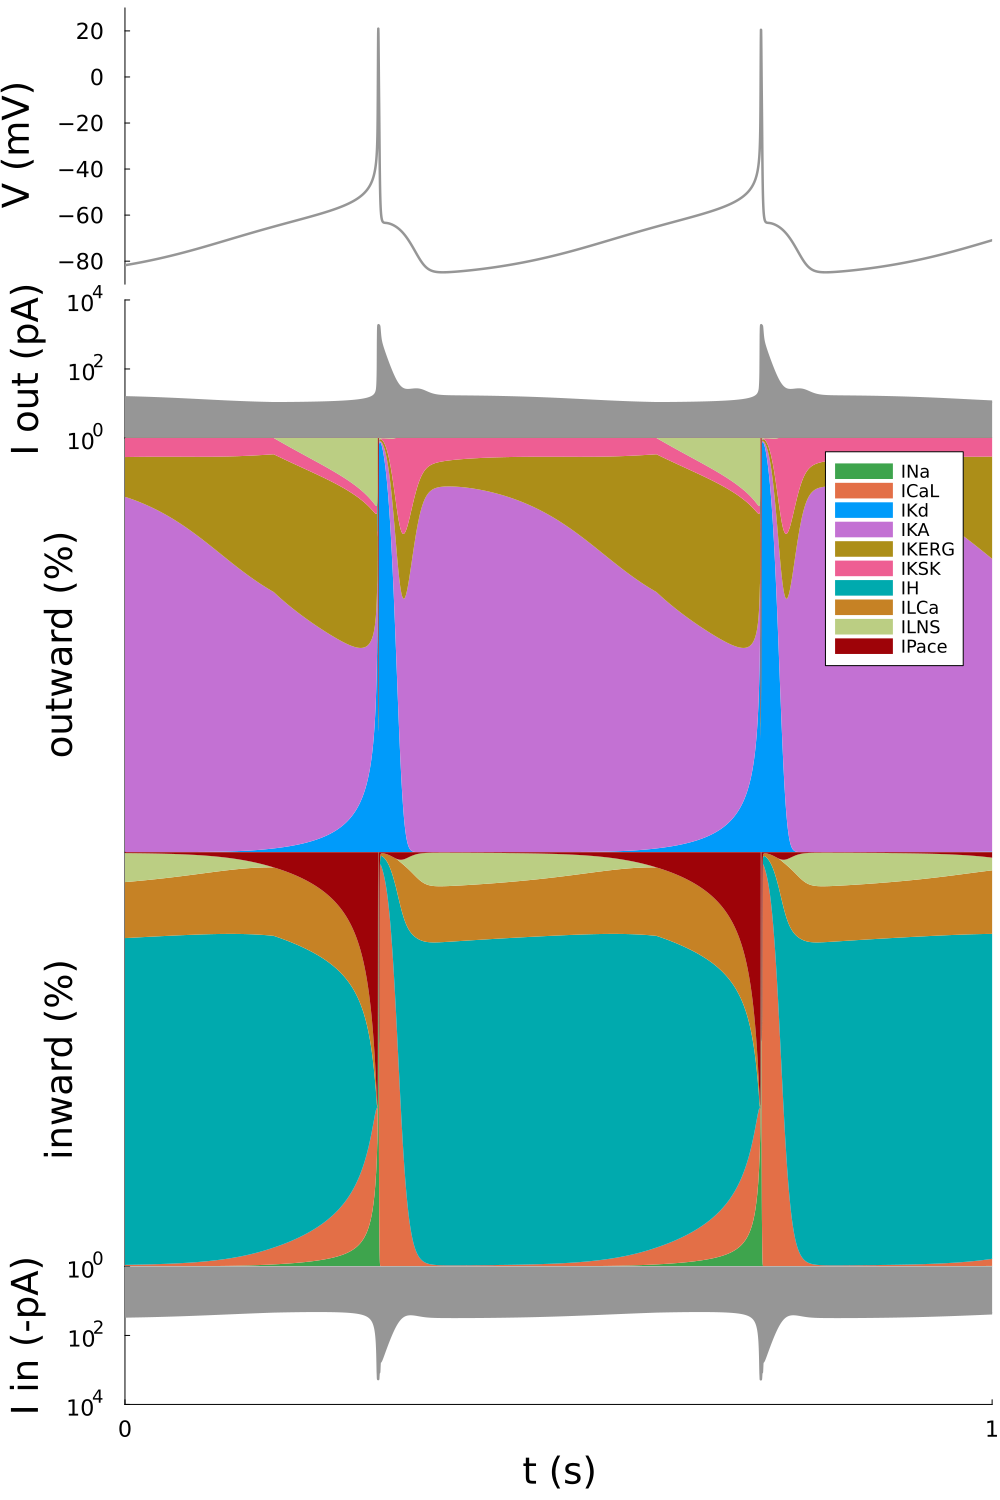

In [42]:
tt_currentscapte = 19000 : 0.1 : 19700
currentscapeAHSK = currentScape(sol_AHSKi, tt_currentscapte, 19, 19.7, p)
display(currentscapeAHSK)
# savefig(currentscapeAHSK, "./figures/fig6_currentscapeAHSK.png")
# savefig(currentscapeAHSK, "./figures/fig6_currentscapeAHSK.pdf")
# savefig(currentscapeAHSK, "./figures/fig6_currentscapeAHSK.svg")

# Without gPace

In [26]:
gNa        = 25. # Sodium current maximal conductance
gCaL       = 1. # L-type calcium current maximal conductance
gKd        = 10. # Delayed-rectifier potassium current maximal conductance
gKA        = 1.68 # A-type potassium current maximal conductance
gKERG      = 0.13 # ERG current maximal conductance
gKSK       = 0.3 # SK current maximal conductance
gH         = 0.078 # H current maximal conductance
gLNS       = 0.01 # Leak non specific current maximal conductance
gLCa       = 0.00245 # Leak calcium current maximal conductance
gPacemaker = 0. # Pacemaker current maximal conductance

# Parameter vector for simulations
Iapp(t) = 0
p = (Iapp, gNa, gCaL, gKd, gKA, gKERG, gKSK, gH, gLNS, gLCa, gPacemaker)

# Initial conditions
V0 = 0.
Ca0 = 1e-4
x0 = [V0, m_inf(V0), h_inf(V0), hs_inf(V0), l_inf(V0), n_inf(V0), p_inf(V0), q1_inf(V0), q2_inf(V0), 
    0., 0., mH_inf(V0), Ca0]

# Simulation
prob = ODEProblem(DA_ODE_true_instant, x0, tspan, p) # Describing the problem
sol_AHSKi = solve(prob, Tsit5(); maxiters=1e9);

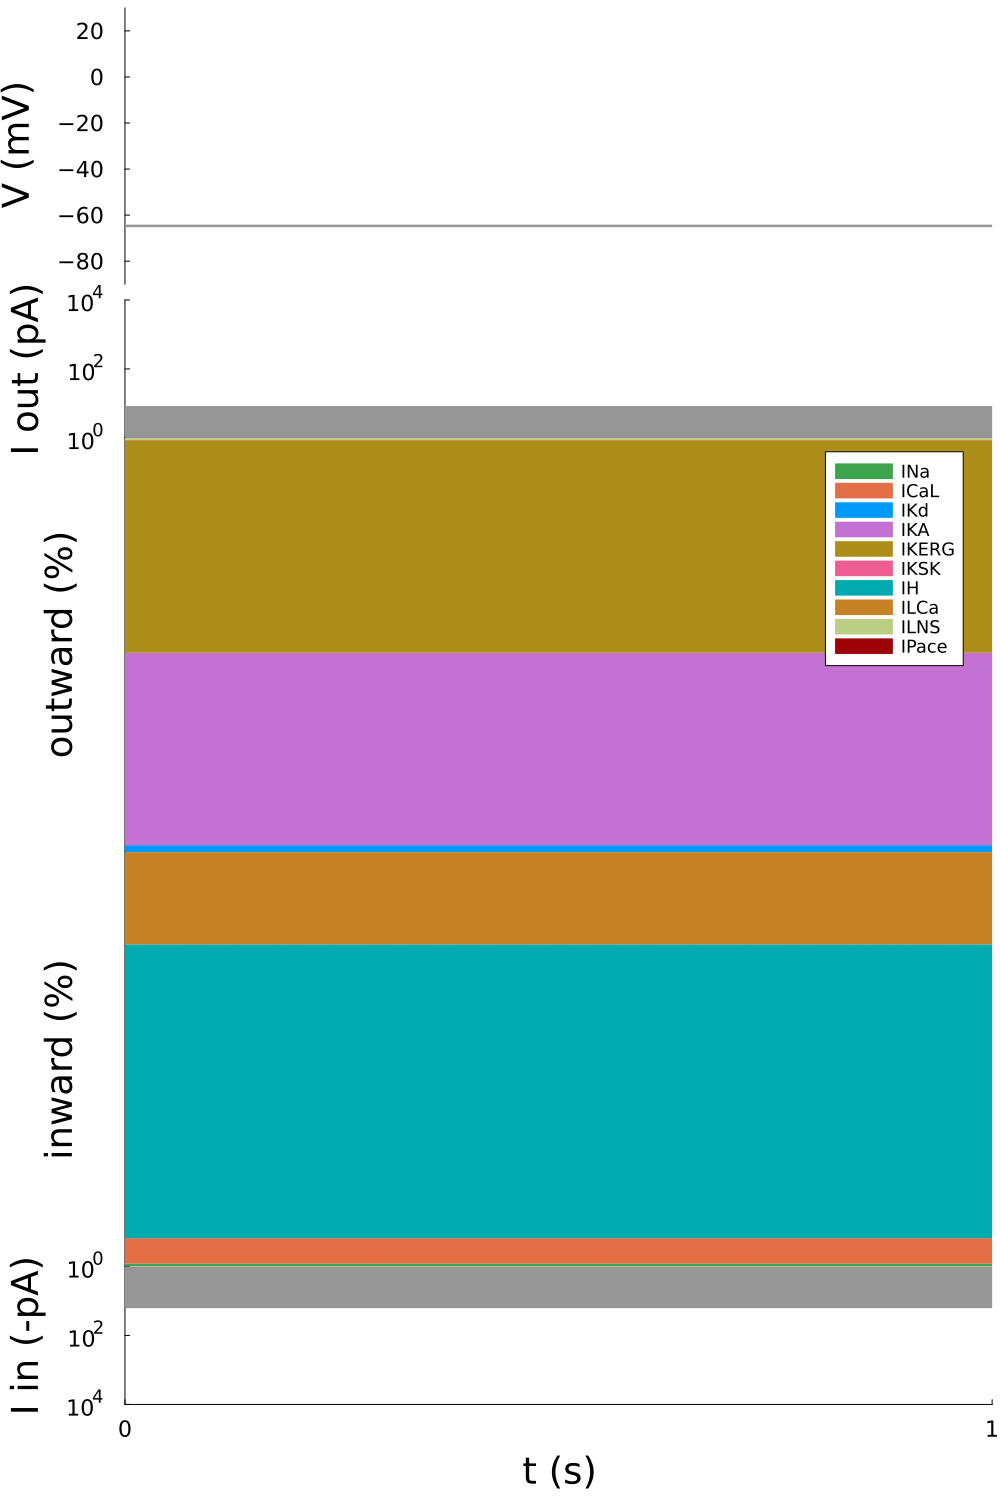

"C:\\Users\\arthu\\GitHub repositories\\Pacemaking_Jehasse\\Canavier model\\figures\\fig6_currentscapeAHSK_noPace.svg"

In [27]:
tt_currentscapte = 19000 : 0.1 : 19700
currentscapeAHSK = currentScape(sol_AHSKi, tt_currentscapte, 19, 19.7, p)
display(currentscapeAHSK)
savefig(currentscapeAHSK, "./figures/fig6_currentscapeAHSK_noPace.png")
savefig(currentscapeAHSK, "./figures/fig6_currentscapeAHSK_noPace.pdf")
savefig(currentscapeAHSK, "./figures/fig6_currentscapeAHSK_noPace.svg")

In [25]:
I_in_gPaceoff, I_out_gPaceoff = computeCurrents(sol_AHSKi, tt_currentscapte, 19, 20, p);

In [95]:
gNa        = 25. # Sodium current maximal conductance
gCaL       = 1. # L-type calcium current maximal conductance
gKd        = 10. # Delayed-rectifier potassium current maximal conductance
gKA        = 1.68 # A-type potassium current maximal conductance
gKERG      = 0.13 # ERG current maximal conductance
gKSK       = 0.3 # SK current maximal conductance
gH         = 0.078 # H current maximal conductance
gLNS       = 0.01 # Leak non specific current maximal conductance
gLCa       = 0.00245 # Leak calcium current maximal conductance
gPacemaker = 0. # Pacemaker current maximal conductance

# Parameter vector for simulations
t_spike = 19221
Iapp(t) = 20 * (t>=t_spike && t < t_spike+10)
p = (Iapp, gNa, gCaL, gKd, gKA, gKERG, gKSK, gH, gLNS, gLCa, gPacemaker)

# Initial conditions
V0 = 0.
Ca0 = 1e-4
x0 = [V0, m_inf(V0), h_inf(V0), hs_inf(V0), l_inf(V0), n_inf(V0), p_inf(V0), q1_inf(V0), q2_inf(V0), 
    0., 0., mH_inf(V0), Ca0]

# Simulation
prob = ODEProblem(DA_ODE_true_instant, x0, tspan, p) # Describing the problem
sol_AHSKi = solve(prob, Tsit5(); maxiters=1e9);

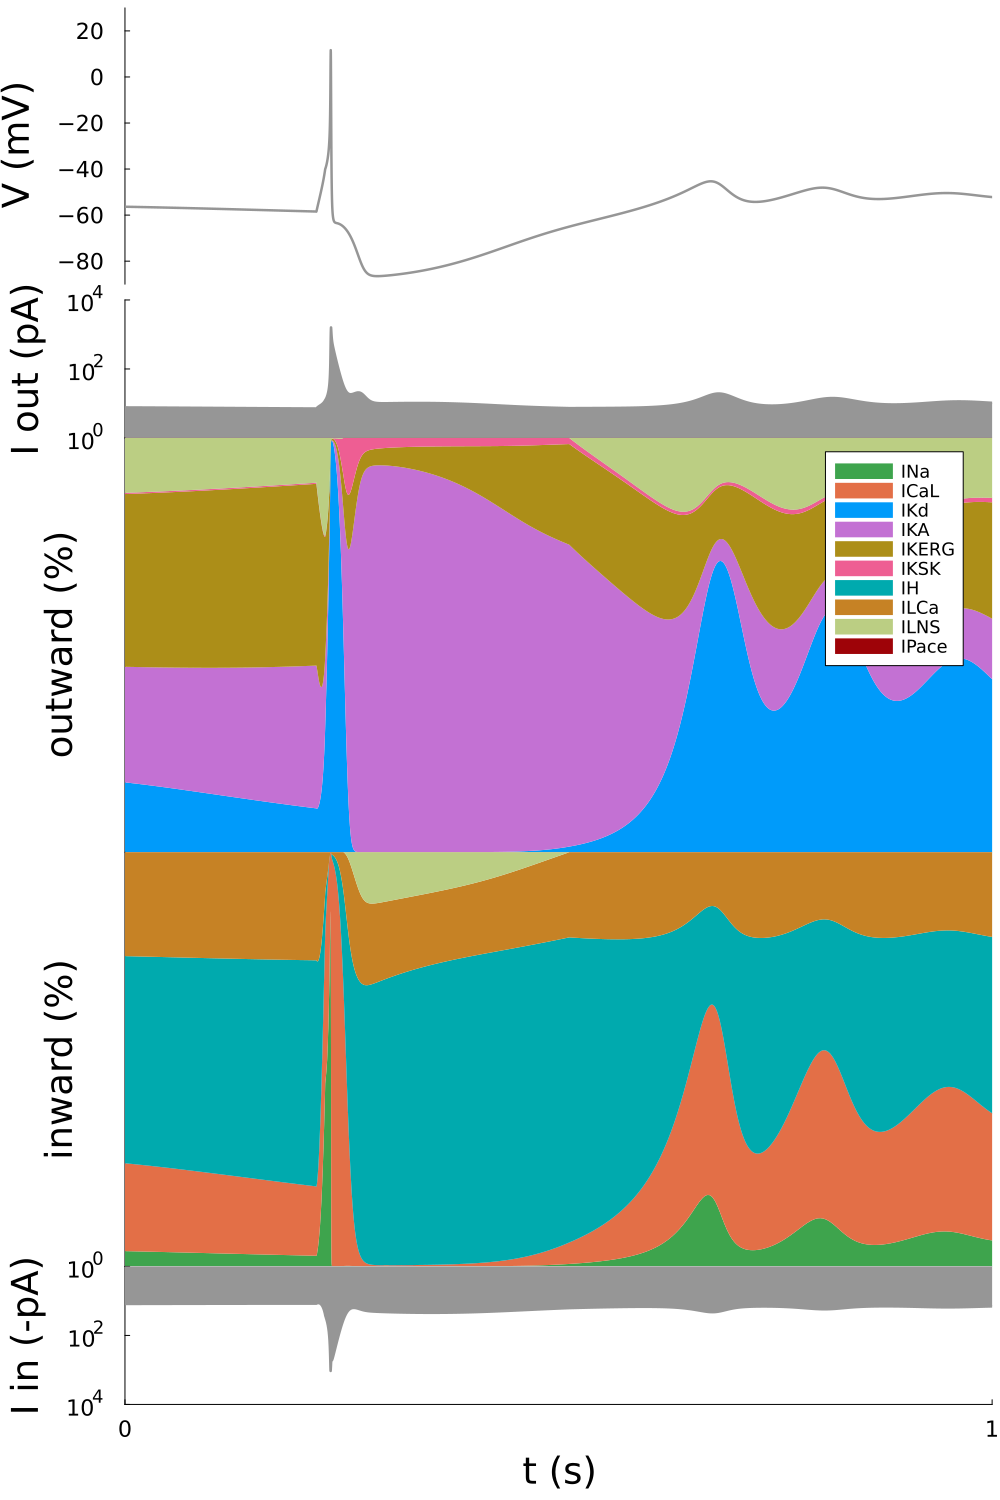

In [104]:
tt_currentscapte = 19000 : 0.1 : 20000
currentscapeAHSK = currentScape(sol_AHSKi, tt_currentscapte, 19, 20, p)
display(currentscapeAHSK)
# savefig(currentscapeAHSK, "./figures/fig6_currentscapeAHSK_noPace_spike.png")
# savefig(currentscapeAHSK, "./figures/fig6_currentscapeAHSK_noPace_spike.pdf")
# savefig(currentscapeAHSK, "./figures/fig6_currentscapeAHSK_noPace_spike.svg")

In [97]:
I_in_gPaceoff_spike, I_out_gPaceoff_spike = computeCurrents(sol_AHSKi, tt_currentscapte, 19, 20, p);

In [21]:
gNa        = 25. # Sodium current maximal conductance
gCaL       = 1. # L-type calcium current maximal conductance
gKd        = 10. # Delayed-rectifier potassium current maximal conductance
gKA        = 1.68 # A-type potassium current maximal conductance
gKERG      = 0.13 # ERG current maximal conductance
gKSK       = 0.3 # SK current maximal conductance
gH         = 0.078 # H current maximal conductance
gLNS       = 0.01 # Leak non specific current maximal conductance
gLCa       = 0.00245 # Leak calcium current maximal conductance
gPacemaker = 0. # Pacemaker current maximal conductance

# Parameter vector for simulations
Iapp(t) = 10
p = (Iapp, gNa, gCaL, gKd, gKA, gKERG, gKSK, gH, gLNS, gLCa, gPacemaker)

# Initial conditions
V0 = 0.
Ca0 = 1e-4
x0 = [V0, m_inf(V0), h_inf(V0), hs_inf(V0), l_inf(V0), n_inf(V0), p_inf(V0), q1_inf(V0), q2_inf(V0), 
    0., 0., mH_inf(V0), Ca0]

# Simulation
prob = ODEProblem(DA_ODE_true_instant, x0, tspan, p) # Describing the problem
sol_AHSKi = solve(prob, Tsit5(); maxiters=1e9);

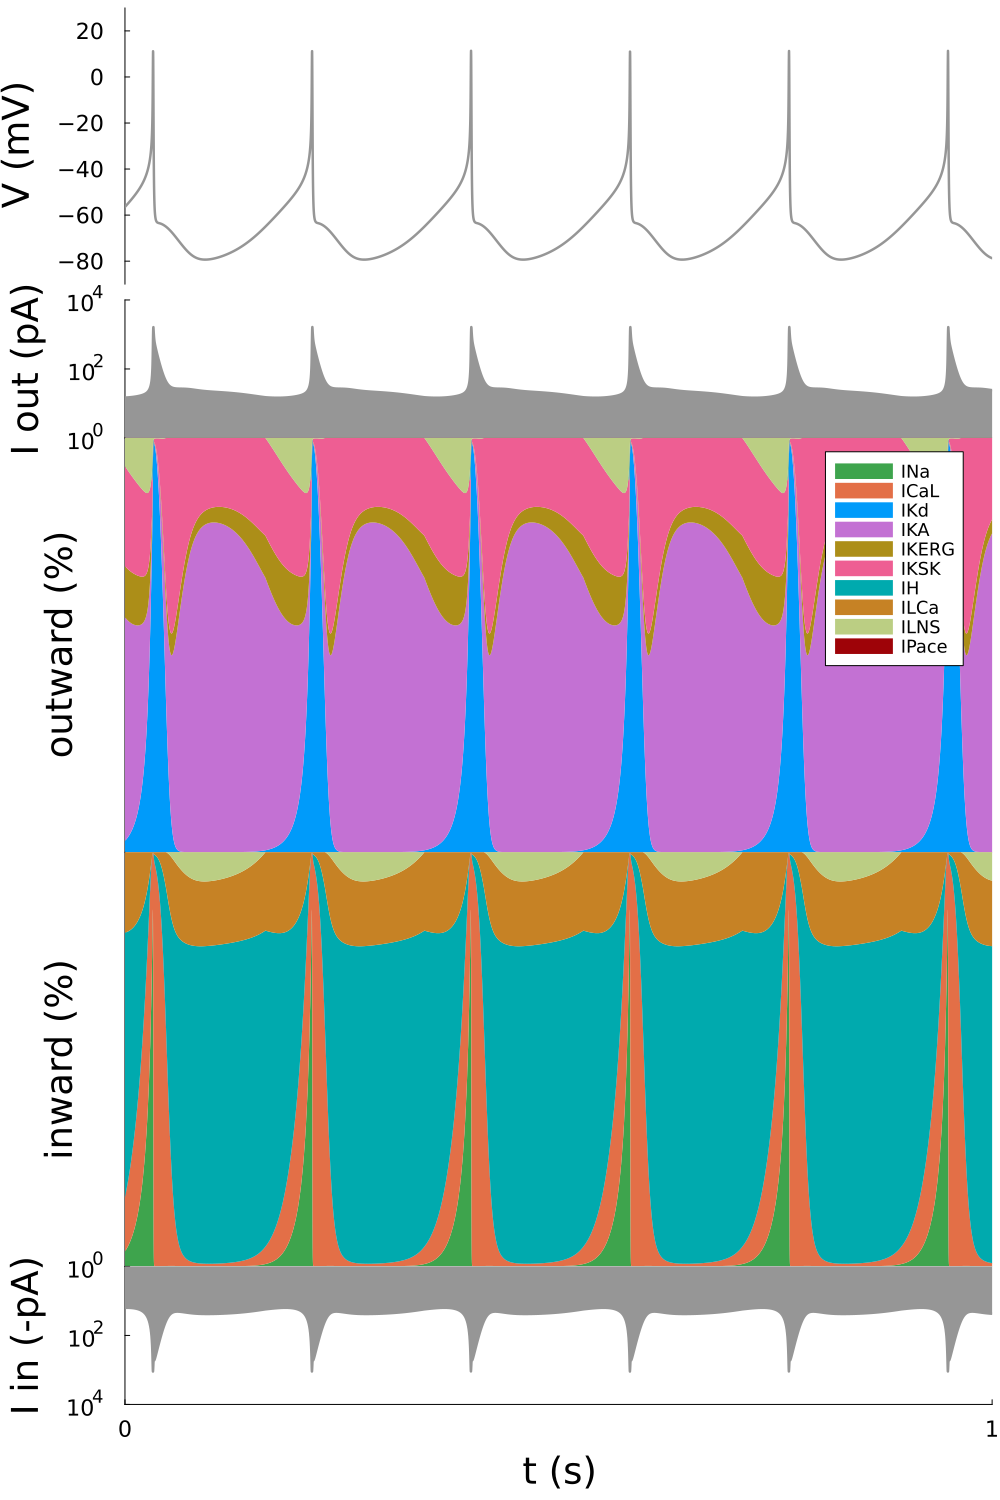

In [22]:
tt_currentscapte = 19000 : 0.1 : 20000
currentscapeAHSK = currentScape(sol_AHSKi, tt_currentscapte, 19, 20, p)
display(currentscapeAHSK)
# savefig(currentscapeAHSK, "./figures/fig6_currentscapeAHSK_noPace_spike.png")
# savefig(currentscapeAHSK, "./figures/fig6_currentscapeAHSK_noPace_spike.pdf")
# savefig(currentscapeAHSK, "./figures/fig6_currentscapeAHSK_noPace_spike.svg")

# Simu noisy model instantaneous with all but Sodium

In [26]:
gNa        = 0. # Sodium current maximal conductance
gCaL       = 1. # L-type calcium current maximal conductance
gKd        = 10. # Delayed-rectifier potassium current maximal conductance
gKA        = 1.68 # A-type potassium current maximal conductance
gKERG      = 0.13 # ERG current maximal conductance
gKSK       = 0.3 # SK current maximal conductance
gH         = 0.078 # H current maximal conductance
gLNS       = 0.01 # Leak non specific current maximal conductance
gLCa       = 0.00245 # Leak calcium current maximal conductance
gPacemaker = 1. # Pacemaker current maximal conductance

# Parameter vector for simulations
Iapp(t) = 0
p = (Iapp, gNa, gCaL, gKd, gKA, gKERG, gKSK, gH, gLNS, gLCa, gPacemaker)

# Initial conditions
V0 = 0.
Ca0 = 1e-4
x0 = [V0, m_inf(V0), h_inf(V0), hs_inf(V0), l_inf(V0), n_inf(V0), p_inf(V0), q1_inf(V0), q2_inf(V0), 
    0., 0., mH_inf(V0), Ca0]

# Simulation
prob = ODEProblem(DA_ODE_true_instant, x0, tspan, p) # Describing the problem
sol_noNai = solve(prob, Tsit5(); maxiters=1e9);

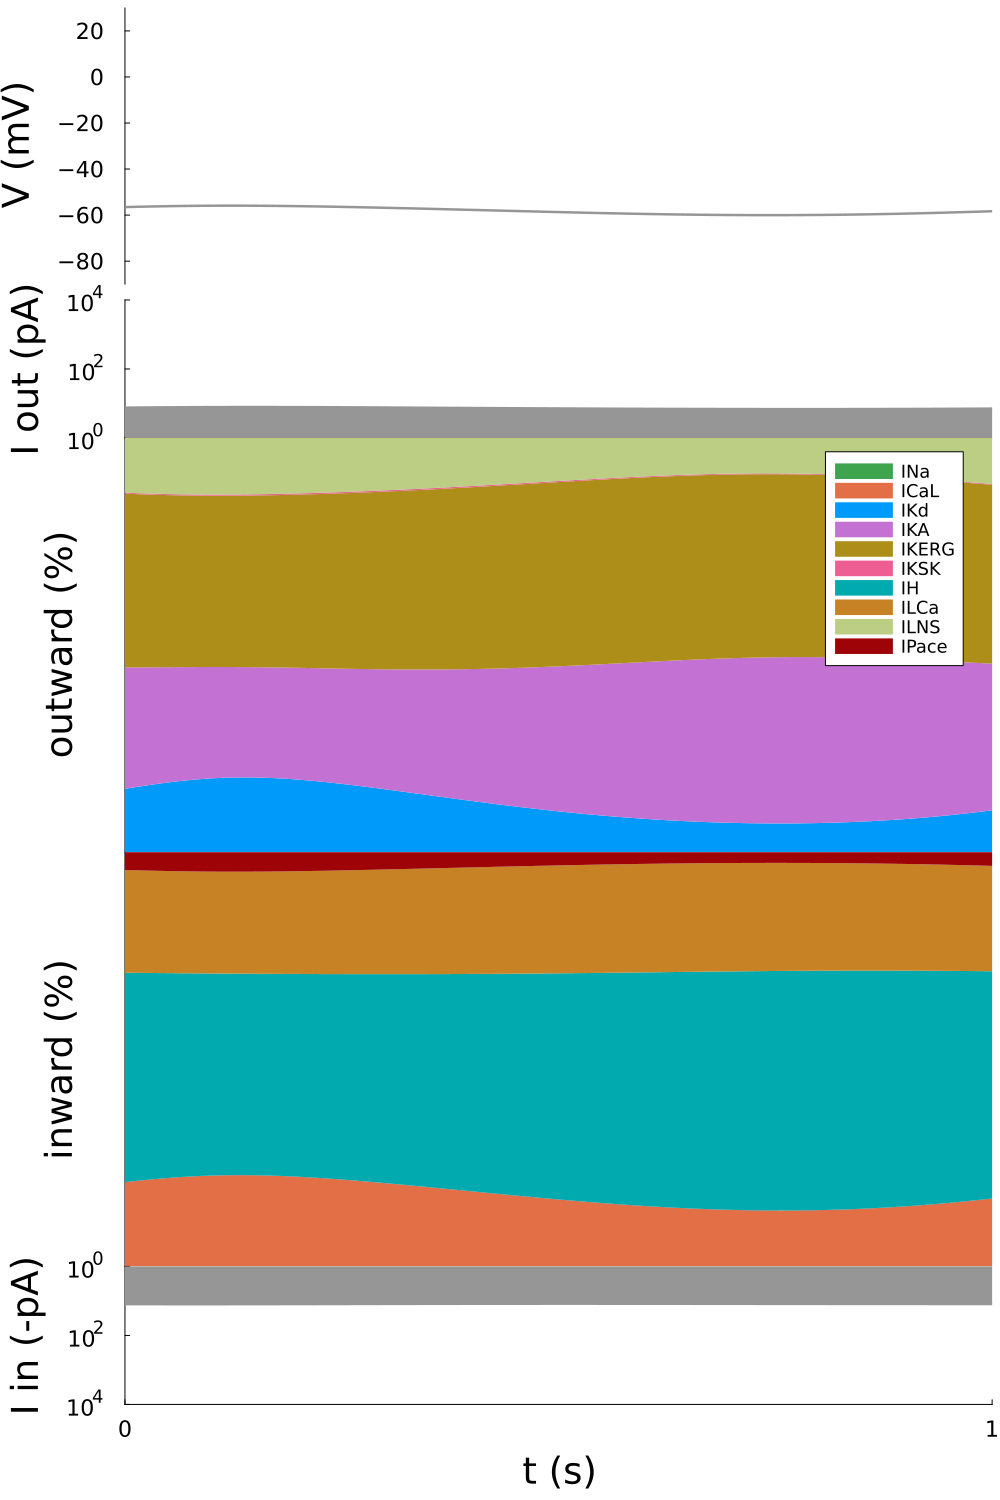

In [27]:
tt_currentscapte = 19000 : 0.1 : 20000
currentscapeNoNa = currentScape(sol_noNai, tt_currentscapte, 19, 20, p)
display(currentscapeNoNa)
# savefig(currentscapeNoNa, "./figures/fig6_currentscapeNoNa.png")
# savefig(currentscapeNoNa, "./figures/fig6_currentscapeNoNa.pdf")
# savefig(currentscapeNoNa, "./figures/fig6_currentscapeNoNa.svg")

# Simu noisy model instantaneous with all but Sodium and XG

In [28]:
gNa        = 0. # Sodium current maximal conductance
gCaL       = 1. # L-type calcium current maximal conductance
gKd        = 10. # Delayed-rectifier potassium current maximal conductance
gKA        = 1.68 # A-type potassium current maximal conductance
gKERG      = 0.13 # ERG current maximal conductance
gKSK       = 0.3 # SK current maximal conductance
gH         = 0.078 # H current maximal conductance
gLNS       = 0.01 # Leak non specific current maximal conductance
gLCa       = 0.00245 # Leak calcium current maximal conductance
gPacemaker = 0. # Pacemaker current maximal conductance

# Parameter vector for simulations
Iapp(t) = 0
p = (Iapp, gNa, gCaL, gKd, gKA, gKERG, gKSK, gH, gLNS, gLCa, gPacemaker)

# Initial conditions
V0 = 0.
Ca0 = 1e-4
x0 = [V0, m_inf(V0), h_inf(V0), hs_inf(V0), l_inf(V0), n_inf(V0), p_inf(V0), q1_inf(V0), q2_inf(V0), 
    0., 0., mH_inf(V0), Ca0]

# Simulation
prob = ODEProblem(DA_ODE_true_instant, x0, tspan, p) # Describing the problem
sol_noNaXGi = solve(prob, Tsit5(); maxiters=1e9);

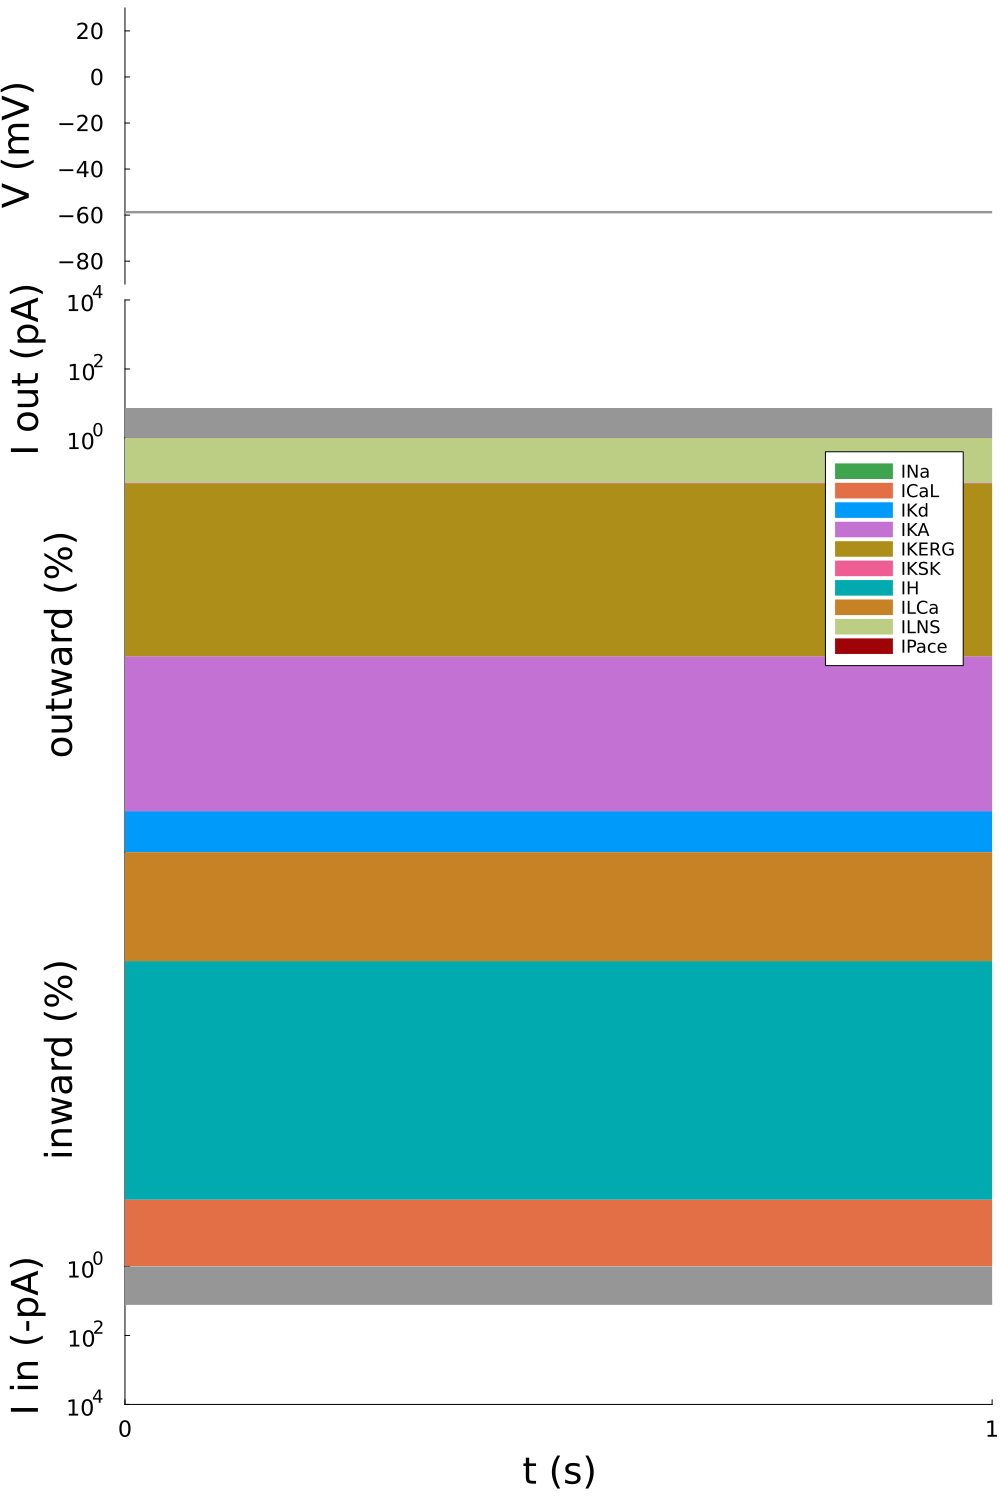

In [29]:
tt_currentscapte = 19000 : 0.1 : 20000
currentscapeNoNaXG = currentScape(sol_noNaXGi, tt_currentscapte, 19, 20, p)
display(currentscapeNoNaXG)
# savefig(currentscapeNoNaXG, "./figures/fig6_currentscapeNoNaXG.png")
# savefig(currentscapeNoNaXG, "./figures/fig6_currentscapeNoNaXG.pdf")
# savefig(currentscapeNoNaXG, "./figures/fig6_currentscapeNoNaXG.svg")

# Total current plot

In [35]:
I_AHSK = I_in_AHSK + I_out_AHSK
I_gPaceoff = I_in_gPaceoff + I_out_gPaceoff
I_gPaceoff_spike = I_in_gPaceoff_spike + I_out_gPaceoff_spike;

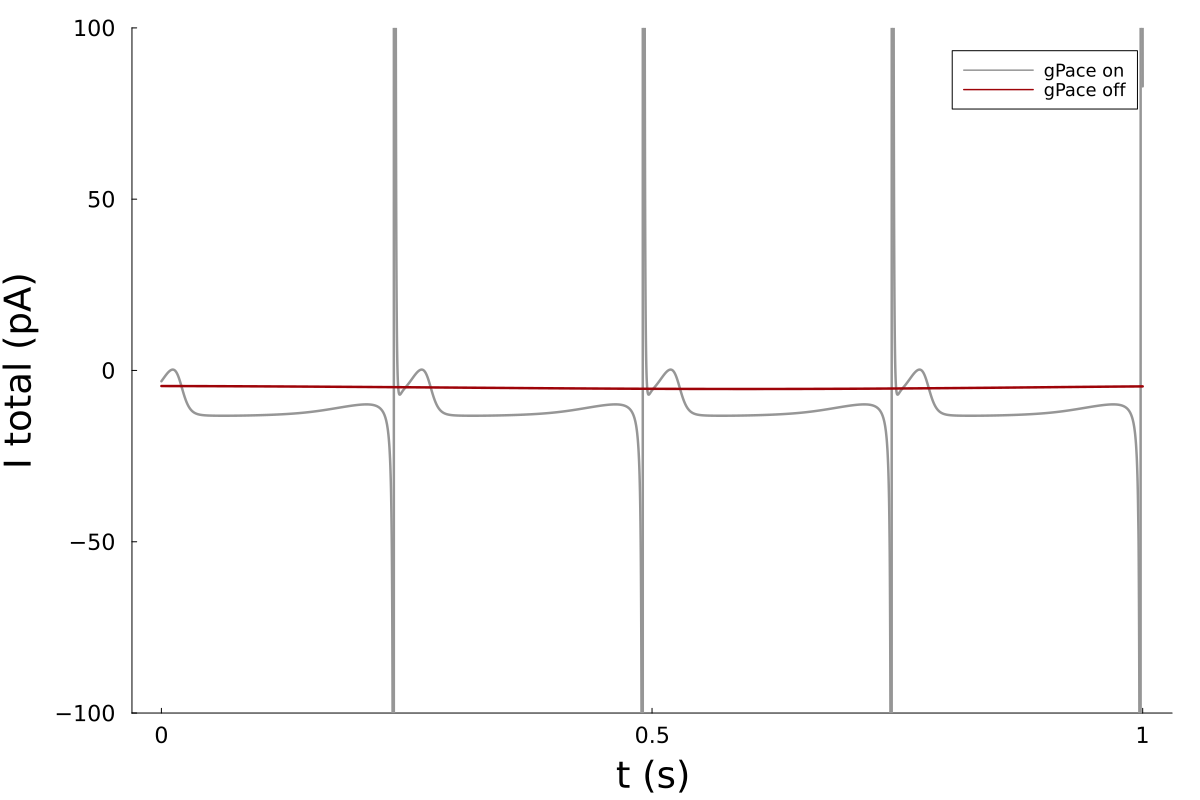

In [107]:
current = plot(tt_currentscapte./1e3, I_AHSK, linewidth=2.5, color=myGray,
    legend=true, label="gPace on", margins=20Plots.px, size=(1200, 800), xticks=([19, 19.5, 20], 
            ["0", "0.5", "1"]), ylims=(-100, 100))
plot!(tt_currentscapte./1e3, I_gPaceoff, linewidth=2.5, color=myRed, label="gPace off")
ylabel!("I total (pA)")
xlabel!("t (s)")

display(current)
# savefig(current, "./figures/fig6_Itot_on_and_off.pdf")
# savefig(current, "./figures/fig6_Itot_on_and_off.svg")

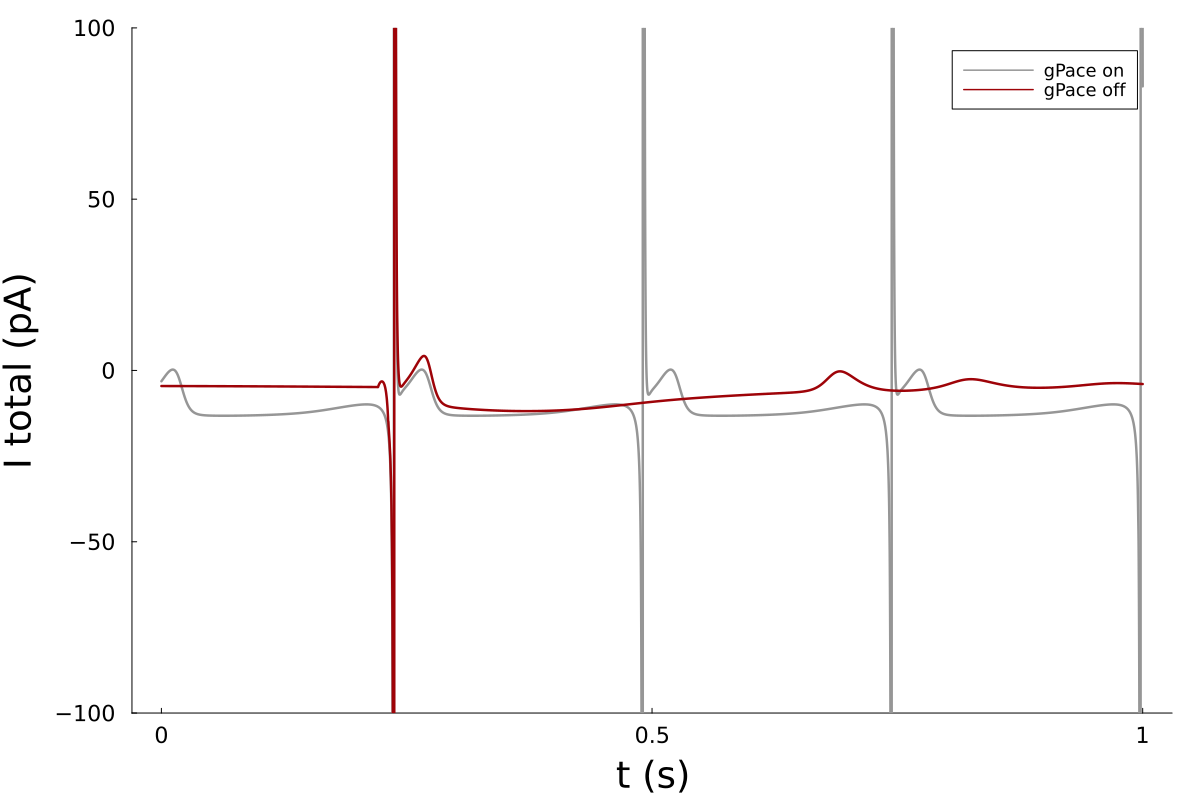

In [109]:
current = plot(tt_currentscapte./1e3, I_AHSK, linewidth=2.5, color=myGray,
    legend=true, label="gPace on", margins=20Plots.px, size=(1200, 800), xticks=([19, 19.5, 20], 
            ["0", "0.5", "1"]), ylims=(-100, 100))
plot!(tt_currentscapte./1e3, I_gPaceoff_spike, linewidth=2.5, color=myRed, label="gPace off")
ylabel!("I total (pA)")
xlabel!("t (s)")

display(current)
# savefig(current, "./figures/fig6_Itot_on_and_off_spike.pdf")
# savefig(current, "./figures/fig6_Itot_on_and_off_spike.svg")

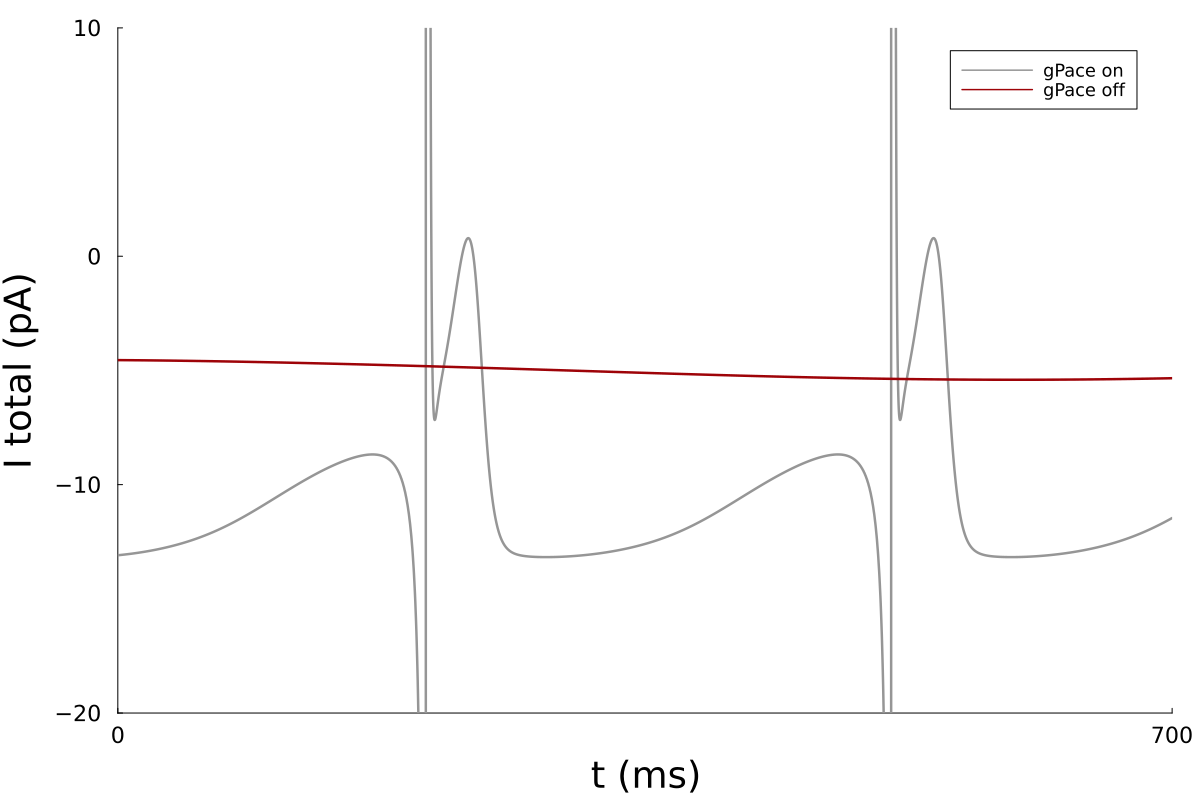

In [34]:
current = plot(tt_currentscapte./1e3, I_AHSK, linewidth=2.5, color=myGray,
    legend=true, label="gPace on", margins=20Plots.px, size=(1200, 800), xticks=([19., 19.7], 
            ["0", "700"]), ylims=(-20, 10), xlims=(19, 19.7))
plot!(tt_currentscapte./1e3, I_gPaceoff, linewidth=2.5, color=myRed, label="gPace off")
ylabel!("I total (pA)")
xlabel!("t (ms)")

display(current)
# savefig(current, "./figures/fig6_Itot_on_and_off_zoom.pdf")
# savefig(current, "./figures/fig6_Itot_on_and_off_zoom.svg")

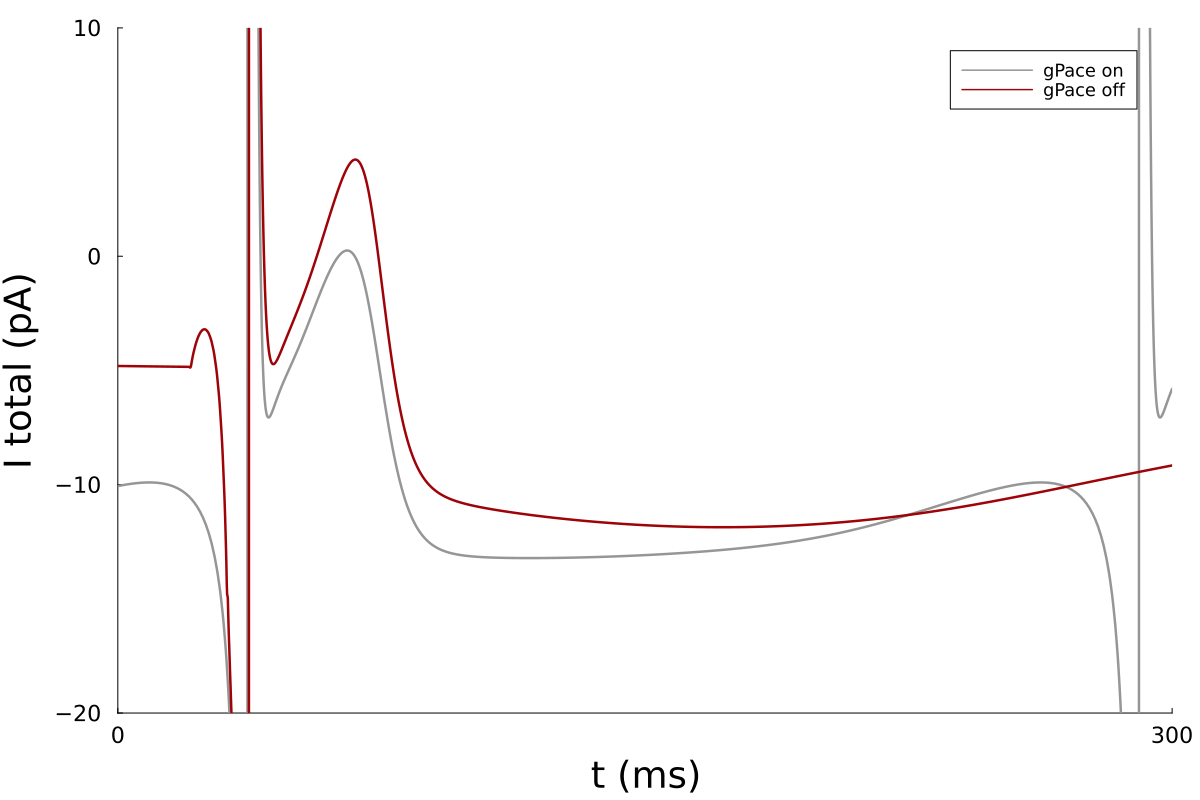

In [113]:
current = plot(tt_currentscapte./1e3, I_AHSK, linewidth=2.5, color=myGray,
    legend=true, label="gPace on", margins=20Plots.px, size=(1200, 800), xticks=([19.2, 19.5], 
            ["0", "300"]), ylims=(-20, 10), xlims=(19.2, 19.5))
plot!(tt_currentscapte./1e3, I_gPaceoff_spike, linewidth=2.5, color=myRed, label="gPace off")
ylabel!("I total (pA)")
xlabel!("t (ms)")

display(current)
# savefig(current, "./figures/fig6_Itot_on_and_off_zoom_spike.pdf")
# savefig(current, "./figures/fig6_Itot_on_and_off_zoom_spike.svg")